In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)

1.14.0


In [1]:
path = './data/ChnSentiCorp_htl_all.csv'

## Read data

In [4]:
pd_all = pd.read_csv(path)

print('评论数目（总体）：%d' % pd_all.shape[0])
print('评论数目（正向）：%d' % pd_all[pd_all.label==1].shape[0])
print('评论数目（负向）：%d' % pd_all[pd_all.label==0].shape[0])

评论数目（总体）：7766
评论数目（正向）：5322
评论数目（负向）：2444


In [4]:
pd_all.head()

,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


In [5]:
pd_positive = pd_all[pd_all.label==1]
pd_negative = pd_all[pd_all.label==0]

def get_balance_corpus(corpus_size, corpus_pos, corpus_neg):
    sample_size = corpus_size // 2
    pd_corpus_balance = pd.concat([corpus_pos.sample(sample_size, replace=corpus_pos.shape[0]<sample_size), \
                                   corpus_neg.sample(sample_size, replace=corpus_neg.shape[0]<sample_size)])
    
    print('Comments number(overall)：%d' % pd_corpus_balance.shape[0])
    print('Comments number(positive)：%d' % pd_corpus_balance[pd_corpus_balance.label==1].shape[0])
    print('Comments number(negative)：%d' % pd_corpus_balance[pd_corpus_balance.label==0].shape[0])    
    
    return pd_corpus_balance

In [6]:
ChnSentiCorp_htl_ba_2000 = get_balance_corpus(4000, pd_positive, pd_negative)

ChnSentiCorp_htl_ba_2000.sample(10)

Comments number(overall)：4000
Comments number(positive)：2000
Comments number(negative)：2000


,label,review
711,1,整体感觉不错，房间不大，色调温和，床松软舒适，刚去过，室内温度挺高，洗澡水放几秒就有热水出来...
3455,1,酒店地理位置不错，硬件设施稍次。总体还可以。
756,1,酒店交通不是很方便，离市区较远，火车站过来大约17、8块，因为地处开发区，住过来的大多数人都...
7027,0,该酒店无论硬件还是软件都达不到4星级。院内停车要交费，房间小，装修档次低，房间床和电视机等档...
4926,1,非常喜欢酒店的服务，我第一次来提了好多意见，比如开夜床没有点心，等等，结果第二天客房就送来点...
3927,1,"门口服务很好,一楼的湖南菜价格也不贵,味道很好!尤其是菜单上没有的菜,他们会安排二楼的餐厅去..."
2580,1,"过年时一家三口在这家酒店住了一周一线海景套房,感觉很不错.房间安静,又能看海,服务也不错.就..."
6168,0,我是四月初去的深圳。我订的是豪华套房，开始在网上开酒店新装修后的照片挺吸引的，但入住后才发现...
504,1,服务很好，按服务中心按钮，提出自己的需求，很快就有人对应。不足是：房间有些小，房子有些旧
4505,1,"到桐庐游玩,4月30日晚上一行9人入住上服假日山庄,总结如下:1.地段不错,距离市中心10分..."


## Preprocessing data

In [7]:
dataset = ChnSentiCorp_htl_ba_2000
dataset.columns = ['label', 'sentence']

In [8]:
import jieba
from string import punctuation
from zhon import hanzi
import re

In [9]:
# remove the punctuations (both English and Chinese)
def remove_punctuation(input_string):
    punc = punctuation + hanzi.punctuation
    output = re.sub(r'[{}]+'.format(punc), '', input_string)
    return output

In [10]:
def jieba_cut(sentence):
    sent_seg = jieba.cut(sentence)
    sent_new = ' '.join(sent_seg)
    sent_new = remove_punctuation(sent_new)
    sent_strip = sent_new.strip()
    return sent_strip

In [11]:
sentence = "任由着，你来了，你走了"
jieba_cut(sentence)


Building prefix dict from the default dictionary ...
I0910 15:25:47.385840 11576 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
I0910 15:25:47.390174 11576 __init__.py:131] Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.659 seconds.
I0910 15:25:49.047349 11576 __init__.py:163] Loading model cost 1.659 seconds.
Prefix dict has been built succesfully.
I0910 15:25:49.050339 11576 __init__.py:164] Prefix dict has been built succesfully.


'任由 着  你 来 了  你 走 了'

In [12]:
dataset = dataset.dropna(axis=0,how='any') #drop all rows that have any NaN values
clean_sent = ['']*len(dataset)
for i in range(len(dataset['sentence'])):
    sent = dataset['sentence'].tolist()[i]
    try:
        clean_sent[i] = jieba_cut(sent)
    except:
        print(sent)
        print(i)

# dataset['sentence_clean'] = clean_sent
# dataset.head(2)               

In [13]:
dataset['clean sentence'] = clean_sent

## Build dictionary

In [14]:
import pickle as pkl
from collections import OrderedDict
import argparse
import os

def build_dictionary(text):
    """
    Build a dictionary
    :param text: list of sentences (pre-tokens)
    :return:
    """
    wordcount = {}
    for cc in text:
        words = cc.split()
        for w in words:
            if w not in wordcount:
                wordcount[w] = 0
            wordcount[w] += 1

    sorted_words = sorted(list(wordcount.keys()), key=lambda x: wordcount[x], reverse=True)

    worddict = OrderedDict()
    worddict["<PAD>"] = 0
    worddict["<UNK>"] = 1
    for idx, word in enumerate(sorted_words):
        worddict[word] = idx+2

#     print("vocab.py: build_dictionary: wordict", worddict, type(worddict))

    return worddict, wordcount

def load_dictionary(loc='./data/faq.txt.pkl'):
    """
    load a dictionary
    :param loc:
    :return:
    """
    print(os.getcwd())
    print("vocab.py:", loc)
    with open(loc, 'rb') as f:
        worddict = pkl.load(f)
        wordcount = pkl.load(f)

    print("vocab.py: worddict", worddict, type(worddict))
    print("vocab.py: wordcount", wordcount)
    return worddict


def save_dictionary(worddict, wordcount, loc):
    """
    Save a dictionary to the specified location
    """
    with open(loc, 'wb') as f:
        pkl.dump(worddict, f)
        pkl.dump(wordcount, f)

def build_and_save_dictionary(text, source):
    save_loc = source+".pkl"
    try:
        cached = load_dictionary(save_loc)
        print("Using cached dictionary at {}".format(save_loc))
        return cached
    except:
        pass
    # build again and save
    print('unable to load from cached, building fresh')
    worddict, wordcount = build_dictionary(text)
    print('Got {} unique words'.format(len(worddict)))
    print('Saving dictionary at {}'.format(save_loc))
    save_dictionary(worddict, wordcount, save_loc)
    return worddict
                   

In [15]:
word_dictionary, _ = build_dictionary(clean_sent) 

In [16]:
len(word_dictionary)

21804

In [17]:
def encode_sent(list_sent, dictionary):
    index = [np.nan]*len(list_sent)
    for i in range(len(list_sent)):
        sent = list_sent[i]
        list_words = jieba_cut(sent).split()
        list_index = [0]*len(list_words)
        for j in range(len(list_words)):
            list_index[j] = dictionary.get(list_words[j], 1)
        index[i] = np.array(list_index)
    return index

        

In [18]:
all_sentence_index = encode_sent(dataset['sentence'].tolist(), word_dictionary)

In [19]:
all_sentence_index[0]

array([ 2919,   625,     6,  5537,    45,    17,     3,    82,     4,
         833,  2105,  2920, 10221,    84,    37,   279,    91,  1059,
          77,   119,   264,   219,     6,    25,    17,  5538,    16,
          84,  2683,    46,   845,  1281,   139,   139,     6,  1059,
          27,  3219,  4627,    28,   234, 10222,    38, 10223,     3,
          11,    84,  2223,    28,    25,    11,   390,    67,   231,
          57,  1996,   481,    10,    11,     2,     6,    10,    56,
          85,   160,   139,   152,   235,    90,   390,    10,    56,
           3,   319,     6,    10,  3582,   755, 10224,     2,    36,
         234,  5539,   152,    30,  7067,     6,     2, 10225,  2921,
           3,    82,    37,  1997, 10226,    46,     2, 10227,  7068,
           3, 10228,     2,  7069])

## padding

In [20]:
from tensorflow import keras

In [21]:
all_data = keras.preprocessing.sequence.pad_sequences(all_sentence_index,
                                                        value=word_dictionary["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

In [22]:
all_data[1,:]

array([  308,   156,   140,     3,   512,  1206,     5,   188,     2,
         341,   554,    63,    18,   280,   129,     8,    20,    44,
         231,  3220,    62,     7,    95,   171,    41,   403,  7070,
        1427,    10,   196,    68,   325,  2922,   168,     9,   834,
         183,  2525,    10,   186,   442,    63,   205,    12,  1902,
         290,     5,   971,   564,   100,    44,   281,   697,     3,
          13,  2526,   127,   198,   506,   608,     2,   741,    85,
           3,    54,    16,   242,     3,   127,    86,    30,     3,
          90,  5540,   578,    16,   917,     3,    62,    33,  2527,
           3,    91,   903,   411,     5,     6,     2,   341,    63,
         688,  1668,    47,   689,   186,  1735,  1669,     2,    13,
          11,   659,  5541,   145,    21,    44,   155,   237,    47,
           2,  2923,  2528,    22, 10229,    13,     5,  3583,    62,
          79,  2923,  3583,   116,   162,   495,    88,   163,   609,
          16,   639,

In [23]:
dataset['sentence index'] = all_data.tolist()

In [24]:
# dataset['sentence index']

In [25]:
dataset.head()

,label,sentence,clean sentence,sentence index
1497,1,同志们.我三四个月住了这酒店至少十一二次.不图什么.就是安静点.上次他们大堂经理跟我说住十次...,同志 们 我 三四个 月 住 了 这 酒店 至少 十一 二次 不图 什么 就是 安静 ...,"[2919, 625, 6, 5537, 45, 17, 3, 82, 4, 833, 21..."
4276,1,帮朋友预定了两天，以下是他的评价：优点：1、服务热情，态度很好。2、送双早。3、房间干净，客...,帮 朋友 预定 了 两天 以下 是 他 的 评价 优点 1 服务 热情 态度 很 ...,"[308, 156, 140, 3, 512, 1206, 5, 188, 2, 341, ..."
1888,1,"典型的快捷酒店的风格，房间不错，淋浴很舒服,早餐十分的丰盛,在郑州当地此酒店好象十分的出名",典型 的 快捷酒店 的 风格 房间 不错 淋浴 很 舒服 早餐 十分 的 丰盛 在 ...,"[1736, 2, 1806, 2, 874, 7, 21, 534, 8, 204, 33..."
4452,1,对本酒店的服务，环境，及房间等设施感觉非常满意并感觉物有所值。下次一定再来。,对本 酒店 的 服务 环境 及 房间 等 设施 感觉 非常 满意 并 感觉 物有所值 ...,"[2106, 4, 2, 18, 70, 345, 7, 105, 43, 32, 35, ..."
3236,1,环境很好，房间不错，网速还可以。早餐不太丰盛，很多都是辣的。选择也不多，看了一圈也没有什么想...,环境 很 好 房间 不错 网速 还 可以 早餐 不太 丰盛 很多 都 是 辣 的 ...,"[70, 8, 20, 7, 21, 860, 15, 26, 33, 519, 1282,..."


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                     dataset['label'], test_size=0.33, random_state=42)

# FastText

In [30]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D, Conv1D
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization, LSTM
from keras import regularizers

## Plot accuracy 

In [28]:
import matplotlib.pyplot as plt
def plot_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, acc, 'bo', label='Training acc')
    # b is for "solid blue line"
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

    plt.show()

### baseline

In [30]:
class FastText():
    
    def __init__(self, VOCAB_SIZE = 2000, EMBEDDING_DIM = 100, MAX_WORDS = 300, CLASS_NUM = 1):
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.MAX_WORDS = MAX_WORDS
        self.CLASS_NUM = CLASS_NUM
        self.model = Sequential()

    def build_fastText(self):
        
        # Embedding 层， 词汇映射为 EMBEDDING_DIM 维度的向量
        self.model.add(Embedding(self.VOCAB_SIZE, self.EMBEDDING_DIM,
                                 input_length=self.MAX_WORDS))
        # 平均文档中的所有单词向量
        self.model.add(GlobalAveragePooling1D())
        # 输出层使用 SoftMax 分类
#         self.model.add(Dense(output_dim=self.CLASS_NUM, activation="softmax"))

        # 输出层使用 tf.nn.sigmoid 
        self.model.add(Dense(output_dim=self.CLASS_NUM, activation=tf.nn.sigmoid))
        



        # 定义模型的损失函数，优化器和分类度量指标
        self.model.compile(loss='binary_crossentropy',
                     optimizer="adam",
                     metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, x_train, y_train, x_val, y_val, epochs=40, batch_size=500, verbose=1):
        history = self.model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=verbose)
        return history
    
    def evaluate(self, test_data, test_labels):
        results = self.model.evaluate(test_data, test_labels)
        return results

In [31]:
VOCAB_SIZE = len(word_dictionary) 
EMBEDDING_DIM = 100
WORD_VEC = None # 256
CLASS_NUM = 1


ft = FastText(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft.build_fastText()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

history1 = ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 40)




W0910 11:29:39.807730 13900 deprecation_wrapper.py:119] From D:\program.successfully\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0910 11:29:39.852613 13900 deprecation_wrapper.py:119] From D:\program.successfully\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0910 11:29:39.856739 13900 deprecation_wrapper.py:119] From D:\program.successfully\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

D:\program.successfully\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation=<function ..., units=1)`
W0910 11:29:39.894497 13900 deprecation_wrapper.py:119] From D:\program.successfully\anaconda3\l

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2112200   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,112,301
Trainable params: 2,112,301
Non-trainable params: 0
_________________________________________________________________
None


W0910 11:29:40.329918 13900 deprecation_wrapper.py:119] From D:\program.successfully\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 2680 samples, validate on 1320 samples
Epoch 1/40
2680/2680 [==============================] - 2s 731us/step - loss: 0.6916 - acc: 0.5168 - val_loss: 0.6883 - val_acc: 0.5583
Epoch 2/40
2680/2680 [==============================] - 1s 385us/step - loss: 0.6894 - acc: 0.5358 - val_loss: 0.6862 - val_acc: 0.5697
Epoch 3/40
2680/2680 [==============================] - 1s 392us/step - loss: 0.6872 - acc: 0.5515 - val_loss: 0.6839 - val_acc: 0.5803
Epoch 4/40
2680/2680 [==============================] - 1s 378us/step - loss: 0.6849 - acc: 0.5612 - val_loss: 0.6816 - val_acc: 0.5902
Epoch 5/40
2680/2680 [==============================] - 1s 385us/step - loss: 0.6823 - acc: 0.5791 - val_loss: 0.6797 - val_acc: 0.5985
Epoch 6/40
2680/2680 [==============================] - 1s 386us/step - loss: 0.6794 - acc: 0.5948 - val_loss: 0.6773 - val_acc: 0.6068
Epoch 7/40
2680/2680 [==============================] - 1s 390us/step - loss: 0.6766 - acc: 0.6082 - val_loss: 0.6746 - val_acc: 0.6189


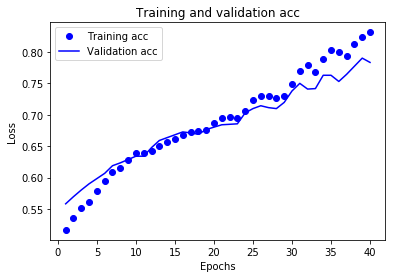

In [32]:
plot_acc(history1)

### Add dropout layer

In [33]:
class FastText2():
    
    def __init__(self, VOCAB_SIZE = 2000, EMBEDDING_DIM = 100, MAX_WORDS = 300, CLASS_NUM = 1):
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.MAX_WORDS = MAX_WORDS
        self.CLASS_NUM = CLASS_NUM
        self.model = Sequential()

    def build_fastText(self):
        
        # Embedding 层， 词汇映射为 EMBEDDING_DIM 维度的向量
        self.model.add(Embedding(self.VOCAB_SIZE, self.EMBEDDING_DIM,
                                 input_length=self.MAX_WORDS))
        # 平均文档中的所有单词向量
        self.model.add(GlobalAveragePooling1D())
        # 输出层使用 SoftMax 分类
#         self.model.add(Dense(output_dim=self.CLASS_NUM, activation="softmax"))

        # 输出层使用 tf.nn.sigmoid 
        self.model.add(Dense(output_dim=self.CLASS_NUM, activation=tf.nn.sigmoid))
        
        # dropout 层
        self.model.add(Dropout(0.25)) 
        



        # 定义模型的损失函数，优化器和分类度量指标
        self.model.compile(loss='binary_crossentropy',
                     optimizer="adam",
                     metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, x_train, y_train, x_val, y_val, epochs=40, batch_size=500, verbose=1):
        history = self.model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=verbose)
        return history
    
    def evaluate(self, test_data, test_labels):
        results = self.model.evaluate(test_data, test_labels)
        return results

In [34]:
VOCAB_SIZE = len(word_dictionary) 
EMBEDDING_DIM = 100
WORD_VEC = None # 256
CLASS_NUM = 1


ft2 = FastText2(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft2.build_fastText()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))


history2 = ft2.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),40)



D:\program.successfully\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation=<function ..., units=1)`
W0910 11:30:25.152342 13900 deprecation.py:506] From D:\program.successfully\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2112200   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
Total params: 2,112,301
Trainable params: 2,112,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 2680 samples, validate on 1320 samples
Epoch 1/40
2680/2680 [==============================] - 2s 736us/step - loss: 2.6135 - acc: 0.4761 - val_loss: 0.6979 - val_acc: 0.4788
Epoch 2/40
2680/2680 [==============================]

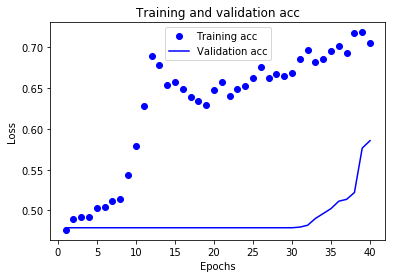

In [35]:
plot_acc(history2)

### add normalization

In [36]:
class FastText3():
    
    def __init__(self, VOCAB_SIZE = 2000, EMBEDDING_DIM = 100, MAX_WORDS = 300, CLASS_NUM = 1):
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.MAX_WORDS = MAX_WORDS
        self.CLASS_NUM = CLASS_NUM
        self.model = Sequential()

    def build_fastText(self):
        
        # Embedding 层， 词汇映射为 EMBEDDING_DIM 维度的向量
        self.model.add(Embedding(self.VOCAB_SIZE, self.EMBEDDING_DIM,
                                 input_length=self.MAX_WORDS))
        # 平均文档中的所有单词向量
        self.model.add(GlobalAveragePooling1D())
        
        # Normalization
        self.model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
                                                   center=True, scale=True, 
                                                   beta_initializer='zeros', gamma_initializer='ones', 
                                                   moving_mean_initializer='zeros', 
                                                   moving_variance_initializer='ones'))
        
        # 输出层使用 SoftMax 分类
#         self.model.add(Dense(output_dim=self.CLASS_NUM, activation="softmax"))

        # 输出层使用 tf.nn.sigmoid 
        self.model.add(Dense(output_dim=self.CLASS_NUM, activation=tf.nn.sigmoid))
        
        # dropout 层
        self.model.add(Dropout(0.25))
        



        # 定义模型的损失函数，优化器和分类度量指标
        self.model.compile(loss='binary_crossentropy',
                     optimizer="adam",
                     metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, x_train, y_train, x_val, y_val, epochs=40, batch_size=500, verbose=1):
        history = self.model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=verbose)
        return history
    
    def evaluate(self, test_data, test_labels):
        results = self.model.evaluate(test_data, test_labels)
        return results

In [37]:
VOCAB_SIZE = len(word_dictionary) 
EMBEDDING_DIM = 100
WORD_VEC = None # 256
CLASS_NUM = 1


ft3 = FastText3(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft3.build_fastText()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

history3 = ft3.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),40)


D:\program.successfully\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation=<function ..., units=1)`


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         2112200   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
Total params: 2,112,701
Trainable params: 2,112,501
Non-trainable params: 200
_________________________________________________________________
None
Train on 2680 samples, validate on 1320 samples
Epoch 1/40
2680/2680 [==============================] -

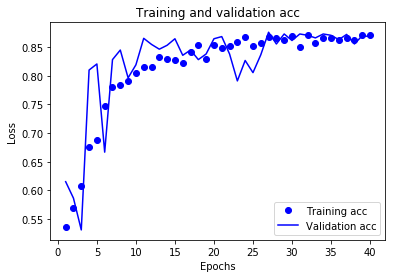

In [38]:
plot_acc(history3)

### Add regularizer

In [39]:
class FastText4():
    
    def __init__(self, VOCAB_SIZE = 2000, EMBEDDING_DIM = 100, MAX_WORDS = 300, CLASS_NUM = 1):
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.MAX_WORDS = MAX_WORDS
        self.CLASS_NUM = CLASS_NUM
        self.model = Sequential()

    def build_fastText(self):
        
        # Embedding 层， 词汇映射为 EMBEDDING_DIM 维度的向量
        self.model.add(Embedding(self.VOCAB_SIZE, self.EMBEDDING_DIM,
                                 input_length=self.MAX_WORDS))
        # 平均文档中的所有单词向量
        self.model.add(GlobalAveragePooling1D())
        
        # Normalization
        self.model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
                                                   center=True, scale=True, 
                                                   beta_initializer='zeros', gamma_initializer='ones', 
                                                   moving_mean_initializer='zeros', 
                                                   moving_variance_initializer='ones'))
        
        # 输出层使用 SoftMax 分类
#         self.model.add(Dense(output_dim=self.CLASS_NUM, activation="softmax"))

        # 输出层使用 tf.nn.sigmoid 
        self.model.add(Dense(output_dim=self.CLASS_NUM, 
                             kernel_regularizer=regularizers.l2(0.01),activation=tf.nn.sigmoid))
        
        # dropout 层
        self.model.add(Dropout(0.25))
        



        # 定义模型的损失函数，优化器和分类度量指标
        self.model.compile(loss='binary_crossentropy',
                     optimizer="adam",
                     metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, x_train, y_train, x_val, y_val, epochs=40, batch_size=500, verbose=1):
        history = self.model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=verbose)
        return history
    
    def evaluate(self, test_data, test_labels):
        results = self.model.evaluate(test_data, test_labels)
        return results

In [40]:
VOCAB_SIZE = len(word_dictionary) 
EMBEDDING_DIM = 100
WORD_VEC = None # 256
CLASS_NUM = 1


ft4 = FastText4(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft4.build_fastText()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

history4 = ft4.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),40)


D:\program.successfully\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_regularizer=<keras.reg..., activation=<function ..., units=1)`


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         2112200   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1)                 0         
Total params: 2,112,701
Trainable params: 2,112,501
Non-trainable params: 200
_________________________________________________________________
None
Train on 2680 samples, validate on 1320 samples
Epoch 1/40
2680/2680 [==============================] -

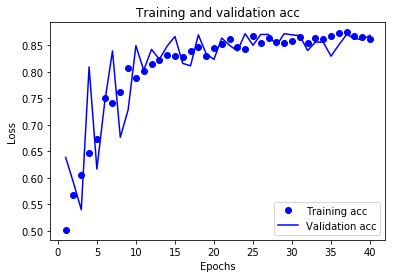

In [41]:
plot_acc(history4)

In [42]:
# 翻倍 embedding 的维度

VOCAB_SIZE = len(word_dictionary)
EMBEDDING_DIM = 200
WORD_VEC = None # 256
CLASS_NUM = 1


ft5 = FastText4(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft5.build_fastText()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

history5 = ft5.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),40)


D:\program.successfully\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_regularizer=<keras.reg..., activation=<function ..., units=1)`


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         4224400   
_________________________________________________________________
global_average_pooling1d_5 ( (None, 200)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
Total params: 4,225,401
Trainable params: 4,225,001
Non-trainable params: 400
_________________________________________________________________
None
Train on 2680 samples, validate on 1320 samples
Epoch 1/40
2680/2680 [==============================] -

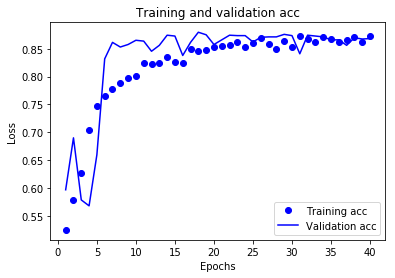

In [43]:
plot_acc(history5)

In [44]:
## 维度没有影响

In [45]:
keras.utils.to_categorical(np.random.randint(3, size=(4, 1)), num_classes=3)

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

# N-gram


In [46]:
dataset.head()

,label,sentence,clean sentence,sentence index
150,1,在上海市中心的位置，因此比较牛气。不过在周围几个酒店里性价比算高的了，大床房难订到。,在 上海市 中心 的 位置 因此 比较 牛气 不过 在 周围 几个 酒店 里 性价比 算...,"[9, 4471, 664, 2, 137, 855, 28, 9853, 90, 9, 3..."
4036,1,如果不想在神仙居景点玩2天以上，那还是应该选择近市区的酒店，否则过了5点以后就要坐出租车上山...,如果 不想 在 神仙 居 景点 玩 2 天 以上 那 还是 应该 选择 近 市区 的 酒店...,"[95, 702, 9, 9855, 6769, 903, 775, 45, 273, 69..."
2884,1,开始订了富凯，虽然住在8楼双号，但是早上7点的时候就能听到下面的国歌声，早操音乐，实在太吵，...,开始 订 了 富凯 虽然 住 在 8 楼双 号 但是 早上 7 点 的 时候 就 能 听...,"[277, 182, 3, 6770, 163, 17, 9, 175, 9858, 442..."
3061,1,"是第二次住了,服务还可以,还加了电脑可以上网。",是 第二次 住 了 服务 还 可以 还加 了 电脑 可以 上网,"[5, 685, 17, 3, 18, 15, 27, 6772, 3, 358, 27, ..."
4877,1,偶住的是南楼的房间，性价比不错！酒店位置很好，离莫家街和清真大寺都很近，走路分别为5分钟，而...,偶住 的 是 南楼 的 房间 性价比 不错 酒店 位置 很 好 离莫家 街 和 清真 ...,"[6773, 2, 5, 2602, 2, 7, 157, 19, 4, 137, 8, 2..."


In [47]:
''.join("纵容着 喜欢的 讨厌的 厌倦的 一个个慢慢暗淡".split())

'纵容着喜欢的讨厌的厌倦的一个个慢慢暗淡'

In [80]:
ngram = 2

# 将n-gram词加入到词表
def create_ngram(sent, ngram_value):
    return set(zip(*[sent[i:] for i in range(ngram_value)]))

ngram_set = set()
for sentence in clean_sent:
    sent = ''.join(sentence.split())
    for i in range(2, ngram+1):
        set_of_ngram = create_ngram(sent, i)
        ngram_set.update(set_of_ngram)


In [81]:
start_index = len(word_dictionary)
ngram_dictionary = {v: k + start_index for k, v in enumerate(ngram_set)} # 给n-gram词汇编码

def add_ngram(origin_sent_index_list, sentence_list, ngram_dictionary, ngram):
    """
    origin_sent_index_list：存放了每个使用word的句子index的列表
    sentence_list: 存放了清洗后原始句子的列表
    ngram_dictionary
    """
    if len(origin_sent_index_list) == len(sentence_list):
        new_sent_indx_list = [np.nan]*len(sentence_list)
        for i in range(len(sentence_list)):
            sent = ''.join(sentence_list[i].split())
            list_of_ngram_index = np.array([])
            for j in range(2, ngram+1):
                list_of_ngram = create_ngram(sent, j)
                for element in list_of_ngram:
                    index = ngram_dictionary.get(element, 0)
                    list_of_ngram_index = np.append(list_of_ngram_index, index)
                    
            new_sent_indx_list[i] = np.append(origin_sent_index_list[i], list_of_ngram_index)
        return new_sent_indx_list
            
#         print(origin_sent_index_list[0])
                    
            
    else:
        print("Length of origin word index list doesn't match length of sentence list")
 


In [82]:
all_sentence_index[0]

array([   9, 4471,  664,    2,  137,  855,   28, 9853,   90,    9,  357,
        385,    4,   72,  157, 6768,    2,    3,  155, 9854,   25])

In [83]:
ngram_data = add_ngram(all_sentence_index, clean_sent, ngram_dictionary, ngram)

In [84]:
ngram_data[0]

array([9.00000e+00, 4.47100e+03, 6.64000e+02, 2.00000e+00, 1.37000e+02,
       8.55000e+02, 2.80000e+01, 9.85300e+03, 9.00000e+01, 9.00000e+00,
       3.57000e+02, 3.85000e+02, 4.00000e+00, 7.20000e+01, 1.57000e+02,
       6.76800e+03, 2.00000e+00, 3.00000e+00, 1.55000e+02, 9.85400e+03,
       2.50000e+01, 6.77300e+04, 1.20769e+05, 5.12650e+04, 9.85630e+04,
       4.53550e+04, 5.29920e+04, 3.44680e+04, 9.40010e+04, 9.66710e+04,
       1.06806e+05, 7.46240e+04, 7.31480e+04, 8.78960e+04, 3.11960e+04,
       1.06455e+05, 5.96000e+04, 4.64710e+04, 1.13475e+05, 1.17415e+05,
       3.06390e+04, 7.13870e+04, 5.53840e+04, 4.21780e+04, 6.30490e+04,
       5.56660e+04, 2.14060e+04, 8.63130e+04, 2.46380e+04, 3.84120e+04,
       3.15570e+04, 7.95430e+04, 5.64360e+04, 7.60250e+04, 3.80050e+04,
       6.03710e+04, 5.31240e+04, 9.03180e+04])

In [85]:
len(ngram_data[0])

58

In [87]:
all_ngram_data = keras.preprocessing.sequence.pad_sequences(ngram_data,
                                           value=0,
                                           padding='post',
                                           maxlen= 150)

In [88]:
all_ngram_data[0]

array([     9,   4471,    664,      2,    137,    855,     28,   9853,
           90,      9,    357,    385,      4,     72,    157,   6768,
            2,      3,    155,   9854,     25,  67730, 120769,  51265,
        98563,  45355,  52992,  34468,  94001,  96671, 106806,  74624,
        73148,  87896,  31196, 106455,  59600,  46471, 113475, 117415,
        30639,  71387,  55384,  42178,  63049,  55666,  21406,  86313,
        24638,  38412,  31557,  79543,  56436,  76025,  38005,  60371,
        53124,  90318,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [89]:
from sklearn.model_selection import train_test_split
print(len(all_ngram_data)==len(all_data))
X_ngram_train, X_ngram_test, y_ngram_train, y_ngram_test = train_test_split(all_ngram_data, 
                                                     dataset['label'], test_size=0.33, random_state=42)

True


In [90]:
X_ngram_train[0]

array([  2065,    240,  10603,   1629,      5,      6,    102,    377,
            2,   1754,  72950,  36569,  96748,  44437,  41663,  95397,
       121433,  89266,  28395,  42542,  30349,  96121, 113477,  34338,
        21217, 112017,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [91]:
VOCAB_SIZE = len(word_dictionary) + len(ngram_dictionary)
EMBEDDING_DIM = 100
WORD_VEC = None # 350
CLASS_NUM = 1


ft6 = FastText4(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft6.build_fastText()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

history6 = ft6.train(np.array(X_ngram_train), np.array(y_ngram_train),
                     np.array(X_ngram_test), np.array(y_ngram_test),20)


D:\program.successfully\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_regularizer=<keras.reg..., activation=<function ..., units=1)`


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 100)         12223900  
_________________________________________________________________
global_average_pooling1d_15  (None, 100)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 100)               400       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
_________________________________________________________________
dropout_14 (Dropout)         (None, 1)                 0         
Total params: 12,224,401
Trainable params: 12,224,201
Non-trainable params: 200
_________________________________________________________________
None
Train on 2680 samples, validate on 1320 samples
Epoch 1/20
2680/2680 [==============================

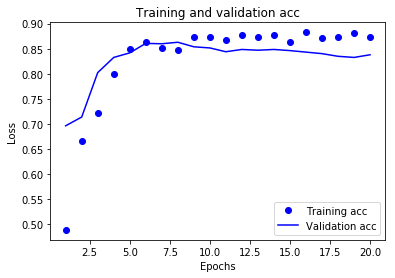

In [92]:
plot_acc(history6)

## modify the order of layers

In [75]:
class FastText5():
    
    def __init__(self, VOCAB_SIZE = 2000, EMBEDDING_DIM = 100, MAX_WORDS = 300, CLASS_NUM = 1):
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.MAX_WORDS = MAX_WORDS
        self.CLASS_NUM = CLASS_NUM
        self.model = Sequential()

    def build_fastText(self):
        
        # Embedding 层， 词汇映射为 EMBEDDING_DIM 维度的向量
        self.model.add(Embedding(self.VOCAB_SIZE, self.EMBEDDING_DIM,
                                 input_length=self.MAX_WORDS))
        # 平均文档中的所有单词向量
        self.model.add(GlobalAveragePooling1D())
        
        # Normalization
        self.model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
                                                   center=True, scale=True, 
                                                   beta_initializer='zeros', gamma_initializer='ones', 
                                                   moving_mean_initializer='zeros', 
                                                   moving_variance_initializer='ones'))
        
        # 输出层使用 SoftMax 分类
#         self.model.add(Dense(output_dim=self.CLASS_NUM, activation="softmax"))

        # dropout 层
        self.model.add(Dropout(0.25))

        # 输出层使用 tf.nn.sigmoid 
        self.model.add(Dense(output_dim=self.CLASS_NUM, 
                             kernel_regularizer=regularizers.l2(0.01),activation=tf.nn.sigmoid))
        

        



        # 定义模型的损失函数，优化器和分类度量指标
        self.model.compile(loss='binary_crossentropy',
                     optimizer="adam",
                     metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, x_train, y_train, x_val, y_val, epochs=40, batch_size=500, verbose=1):
        history = self.model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=verbose)
        return history
    
    def evaluate(self, test_data, test_labels):
        results = self.model.evaluate(test_data, test_labels)
        return results

In [78]:
# 翻倍 embedding 的维度

VOCAB_SIZE = len(word_dictionary)
EMBEDDING_DIM = 200
WORD_VEC = None # 256
CLASS_NUM = 1


ft7 = FastText5(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft7.build_fastText()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

history7 = ft7.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),40)


D:\program.successfully\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_regularizer=<keras.reg..., activation=<function ..., units=1)`


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 200)         4224400   
_________________________________________________________________
global_average_pooling1d_14  (None, 200)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 200)               800       
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 201       
Total params: 4,225,401
Trainable params: 4,225,001
Non-trainable params: 400
_________________________________________________________________
None
Train on 2680 samples, validate on 1320 samples
Epoch 1/40
2680/2680 [==============================] 

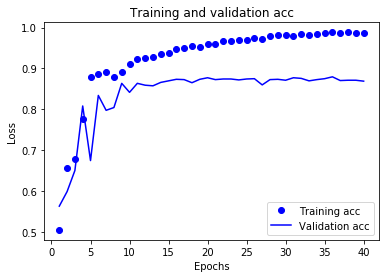

In [79]:
plot_acc(history7)

# LSTM 序列

In [41]:
class FastText6():
    
    def __init__(self, VOCAB_SIZE = 2000, EMBEDDING_DIM = 100, MAX_WORDS = 300, CLASS_NUM = 1):
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.MAX_WORDS = MAX_WORDS
        self.CLASS_NUM = CLASS_NUM
        self.model = Sequential()

    def build_fastText(self):
        
        # Embedding 层， 词汇映射为 EMBEDDING_DIM 维度的向量
        self.model.add(Embedding(self.VOCAB_SIZE, self.EMBEDDING_DIM,
                                 input_length=self.MAX_WORDS))
        
        self.model.add(LSTM(128))
        
        # 平均文档中的所有单词向量
        self.model.add(GlobalAveragePooling1D())
        
        # LSTM 层
#         self.model.add(LSTM(128))
        
        # Normalization
        self.model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
                                                   center=True, scale=True, 
                                                   beta_initializer='zeros', gamma_initializer='ones', 
                                                   moving_mean_initializer='zeros', 
                                                   moving_variance_initializer='ones'))
        
        # 输出层使用 SoftMax 分类
#         self.model.add(Dense(output_dim=self.CLASS_NUM, activation="softmax"))

        # dropout 层
        self.model.add(Dropout(0.25))

        # 输出层使用 tf.nn.sigmoid 
        self.model.add(Dense(output_dim=self.CLASS_NUM, 
                             kernel_regularizer=regularizers.l2(0.01),activation=tf.nn.sigmoid))
        

        



        # 定义模型的损失函数，优化器和分类度量指标
        self.model.compile(loss='binary_crossentropy',
                     optimizer="adam",
                     metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, x_train, y_train, x_val, y_val, epochs=40, batch_size=500, verbose=1):
        history = self.model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=verbose)
        return history
    
    def evaluate(self, test_data, test_labels):
        results = self.model.evaluate(test_data, test_labels)
        return results

In [42]:
# 翻倍 embedding 的维度

VOCAB_SIZE = len(word_dictionary)
EMBEDDING_DIM = 200
WORD_VEC = None # 256
CLASS_NUM = 1


ft8 = FastText6(VOCAB_SIZE, EMBEDDING_DIM, WORD_VEC, CLASS_NUM)
ft8.build_fastText()
ft8.model.summary()
# ft.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

history8 = ft8.train(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),40)


ValueError: Input 0 is incompatible with layer global_average_pooling1d_4: expected ndim=3, found ndim=2

In [37]:
X_train

array([[   32,  2749,     2, ...,     0,     0,     0],
       [19892,   333,  1048, ...,     0,     0,     0],
       [ 3291,    13,   452, ...,     0,     0,     0],
       ...,
       [   14,  1396,  2854, ...,     0,     0,     0],
       [    7,   252,    11, ...,     0,     0,     0],
       [ 1059,    23,   444, ...,     0,     0,     0]])